In [1]:
!pip install pytorch-metric-learning        # Biblioteka metod głębokiego uczenia metryki (deep metric learning)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 109 kB 5.1 MB/s 


In [77]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, models, transforms
from pytorch_metric_learning import samplers, miners, losses

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os

In [3]:
!nvidia-smi

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

Sun Jun  5 09:34:49 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Prepare data

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
!python bboxes_extractor.py --save-dir data/reference_images_part1_bboxes --dir-from /content/drive/MyDrive/data/reference_images_part1 --data-json /content/drive/MyDrive/data/reference_images_part1.json

In [6]:
!python bboxes_extractor.py --save-dir data/images_part1_valid_bboxes --dir-from /content/drive/MyDrive/data/images_part1_valid --data-json /content/drive/MyDrive/data/images_part1_valid.json

# Dataset

In [11]:
from typing import Optional, Callable, Tuple, Any
import numpy as np
from PIL import Image
import os


class MagicDataset(torch.utils.data.Dataset):
    def __init__(
        self, 
        img_dir: str,
        labels_file: Optional[str] = None,
        transform: Optional[Callable] = None,
        target_transform: Optional[Callable] = None
    ) -> None:

        self.img_dir = img_dir
        self.labels_file = labels_file
        self.data = pd.read_csv(labels_file)
        self.img_names = self.data.loc[:, "filename"]
        self.img_labels = self.data.loc[:, "category_id"]
        self.class_names = self.img_labels.unique()

        self.transform = transform
        self.target_transform = target_transform

    def __len__(self) -> int:
        return len(self.img_names)

    def __getitem__(self, index: int):
        img_path = os.path.join(self.img_dir, self.img_names[index])
        image = Image.open(img_path).convert('RGB')
        label = self.img_labels[index]

        if self.transform:
            image = self.transform(image)
            
        if self.target_transform:
            label = self.target_transform(label)

        return image, label
    

In [12]:
IMG_DIR = './data/reference_images_part1_bboxes/images'
LABELS_FILE = './data/reference_images_part1_bboxes/bboxes_data.csv'
IMG_DIR_VAL = './data/images_part1_valid_bboxes/images'
LABELS_FILE_VAL = './data/images_part1_valid_bboxes/bboxes_data.csv'

In [50]:
transformations = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

aug_transformations = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ColorJitter(),
    transforms.RandomRotation(degrees=180),                                      
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [51]:
aug_train_data = MagicDataset(img_dir=IMG_DIR, labels_file=LABELS_FILE, transform=aug_transformations)
train_data = MagicDataset(img_dir=IMG_DIR, labels_file=LABELS_FILE, transform=transformations)
val_data = MagicDataset(img_dir=IMG_DIR_VAL, labels_file=LABELS_FILE_VAL, transform=transformations)

In [52]:
# EXAMPLES_PER_CLASS = 2
# train_sampler = samplers.MPerClassSampler(labels=train_data.class_names, m=EXAMPLES_PER_CLASS)
# val_sampler = samplers.MPerClassSampler(labels=val_data.class_names, m=EXAMPLES_PER_CLASS)

In [53]:
BATCH_SIZE = 256
# train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, sampler=train_sampler)
# val_loader = torch.utils.data.DataLoader(val_data, batch_size=BATCH_SIZE, sampler=val_sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False)
aug_train_loader = torch.utils.data.DataLoader(aug_train_data, batch_size=BATCH_SIZE, shuffle=True)

In [54]:
def imshow(img, title=None):
    """Imshow for Tensor."""
    img = img.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean # unnormalize 
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

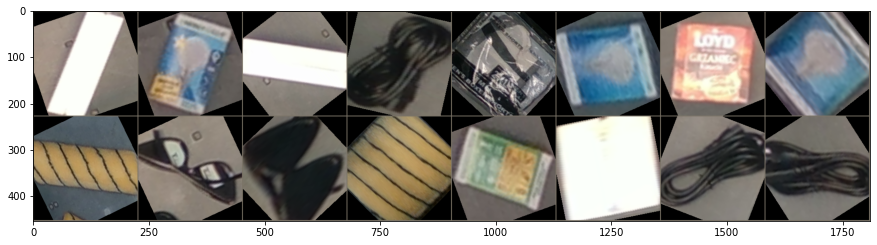

In [55]:
images, labels = next(iter(aug_train_loader))

plt.rcParams['figure.figsize'] = 15, 10
imshow(torchvision.utils.make_grid(images[:16]))

# Model 

In [56]:
EMBEDDING_SIZE = 256

model = models.resnet50(pretrained=True)

num_ftrs = model.fc.in_features
model.avgpool = nn.AdaptiveAvgPool2d(output_size=1)

model.fc = nn.Sequential(
    nn.Linear(num_ftrs, 512),
    nn.Linear(512, EMBEDDING_SIZE),
)

for i, child in enumerate(model.children()):
    if i < 7:
        for param in child.parameters():
            param.requires_grad = False

for param in model.named_parameters():
    if param[1].requires_grad:
        print(param[0])

model = model.to(device)

layer4.0.conv1.weight
layer4.0.bn1.weight
layer4.0.bn1.bias
layer4.0.conv2.weight
layer4.0.bn2.weight
layer4.0.bn2.bias
layer4.0.conv3.weight
layer4.0.bn3.weight
layer4.0.bn3.bias
layer4.0.downsample.0.weight
layer4.0.downsample.1.weight
layer4.0.downsample.1.bias
layer4.1.conv1.weight
layer4.1.bn1.weight
layer4.1.bn1.bias
layer4.1.conv2.weight
layer4.1.bn2.weight
layer4.1.bn2.bias
layer4.1.conv3.weight
layer4.1.bn3.weight
layer4.1.bn3.bias
layer4.2.conv1.weight
layer4.2.bn1.weight
layer4.2.bn1.bias
layer4.2.conv2.weight
layer4.2.bn2.weight
layer4.2.bn2.bias
layer4.2.conv3.weight
layer4.2.bn3.weight
layer4.2.bn3.bias
fc.0.weight
fc.0.bias
fc.1.weight
fc.1.bias


In [58]:
from pytorch_metric_learning.distances import CosineSimilarity

NUM_EPOCHS = 200
MARGIN = 5 # 0.05

miner = miners.BatchHardMiner()
criterion = losses.TripletMarginLoss(margin=MARGIN, distance = CosineSimilarity())
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

model.train()

for epoch in range(NUM_EPOCHS):
    epoch_loss = 0.0
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        embeddings = model(inputs)
        triplets = miner(embeddings, labels)
        loss = criterion(embeddings, labels, triplets)

        epoch_loss += loss.item()
 
        loss.backward()
        optimizer.step()
    
    print(f"[{epoch+1}/{NUM_EPOCHS}] Loss: {epoch_loss / len(train_loader)}")



[1/200] Loss: 5.087947368621826
[2/200] Loss: 4.985413074493408
[3/200] Loss: 4.937594890594482
[4/200] Loss: 4.843044757843018
[5/200] Loss: 4.632704734802246
[6/200] Loss: 4.343180179595947
[7/200] Loss: 4.230181694030762
[8/200] Loss: 4.210148811340332
[9/200] Loss: 4.208974361419678
[10/200] Loss: 4.230306625366211
[11/200] Loss: 4.203489780426025
[12/200] Loss: 4.217060565948486
[13/200] Loss: 4.204794406890869
[14/200] Loss: 4.1893534660339355
[15/200] Loss: 4.157617092132568
[16/200] Loss: 4.15569543838501
[17/200] Loss: 4.166968822479248
[18/200] Loss: 4.123585224151611
[19/200] Loss: 4.110810279846191
[20/200] Loss: 4.106366157531738
[21/200] Loss: 4.078266620635986
[22/200] Loss: 4.071697235107422
[23/200] Loss: 4.075287818908691
[24/200] Loss: 4.085171222686768
[25/200] Loss: 4.076489448547363
[26/200] Loss: 4.068089008331299
[27/200] Loss: 4.062796115875244
[28/200] Loss: 4.065069198608398
[29/200] Loss: 4.069432735443115
[30/200] Loss: 4.061826229095459
[31/200] Loss: 4.03

In [68]:
def tensor_to_image(x):
  # Konwersja obrazu danego jako znormalizowany tensor do PIL Image
  transform = transforms.Compose([transforms.Normalize([0., 0., 0.], [1/0.229, 1/0.224, 1/0.225]),
                       transforms.Normalize([-0.485, -0.456, -0.406], std = [1.,1.,1.]),
                       transforms.ToPILImage()])
  image = transform(x.cpu())
  return image

In [117]:
def show_triplet(batch, i, model):
  # Wygeneruj trójki uczące i wyświetl i-tą trójkę ze wsadu
  x, labels = batch
  x = x.to(device)
  embeddings = model(x)
  labels = labels.to(device)
  triplets = miner(embeddings, labels)
  anchors, positives, negatives = triplets

  fig, axis = plt.subplots(1, 3)
  anchor_ndx = anchors[i]
  positive_ndx = positives[i]
  negative_ndx = negatives[i]
  
  anchor2neg_dist = F.cosine_similarity(embeddings[anchor_ndx], embeddings[negative_ndx], axis=0)
  anchor2pos_dist = F.cosine_similarity(embeddings[anchor_ndx], embeddings[positive_ndx], axis=0)

  fig.suptitle('Trójka ucząca: przykład bazowy (anchor), pozytywny i negatywny')
  axis[0].imshow(tensor_to_image(x[anchor_ndx]))
  axis[0].set_xlabel(f'Anchor\nid produktu: {labels[anchor_ndx].item()}')
  axis[1].imshow(tensor_to_image(x[positives[i]]))
  axis[1].set_xlabel(f'Pozytyw\nid osoby: {labels[positive_ndx].item()}\nOdległość {anchor2pos_dist:0.3f}')
  axis[2].imshow(tensor_to_image(x[negatives[i]]))
  axis[2].set_xlabel(f'Negatyw\nid osoby: {labels[negative_ndx].item()}\nOdległość {anchor2neg_dist:0.3f}')

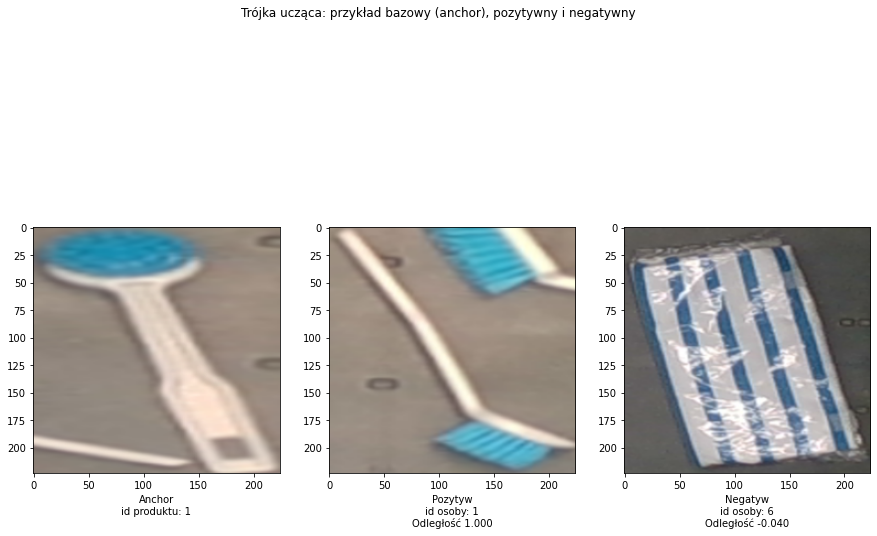

In [118]:
import random
# Wygeneruj i wyświetl losową trójkę uczącą (triplet)
batch = next(iter(train_loader))

i = random.randrange(len(batch))
show_triplet(batch, i, model)

In [42]:
model

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)


In [62]:
model.eval()

embeddings = torch.zeros((0, EMBEDDING_SIZE))
labels = torch.zeros((0))

with torch.no_grad():
    for ins, lbs in train_loader:
        ins = ins.to(device)
        lbs = lbs.to(device)
        
        labels = torch.cat([labels.cpu(), lbs.cpu()])
        embeddings = torch.cat([embeddings.cpu(), model(ins).cpu()], dim=0)
    

In [63]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=1, metric='cosine')
knn.fit(embeddings.numpy(), labels.numpy())

KNeighborsClassifier(metric='cosine', n_neighbors=1)

In [64]:
labels_val = torch.zeros((0))
embeddings_val = torch.zeros((0, EMBEDDING_SIZE))

with torch.no_grad():
    for ins, lbs in val_loader:
        ins = ins.to(device)
        lbs = lbs.to(device)
        
        labels_val = torch.cat([labels_val.cpu(), lbs.cpu()])
        embeddings_val = torch.cat([embeddings_val.cpu(), model(ins).cpu()], dim=0)

In [ ]:
PATH_TO_SAVE = 'drive/data'

torch.save(labels_val, os.path.join(PATH_TO_SAVE, 'labels_val.pt'))
torch.save(embeddings_val, os.path.join(PATH_TO_SAVE, 'embeddings_val.pt'))

In [65]:
embeddings_val.numpy().shape

(6590, 256)

In [66]:
preds = knn.predict(embeddings_val.numpy())

In [67]:
from sklearn.metrics import accuracy_score

print("Accuracy: ", accuracy_score(labels_val.numpy(), preds))

Accuracy:  0.5493171471927162


# Save model

In [119]:
torch.save(model.state_dict(), 'model.pth')